# План работы

### Шаг 1. Открытие и предварительный анализ данных

### Шаг 2. Подготовка данных
#### 1. Удаление пропусков
#### 2. Удаление дубликатов
#### 3. Перевод в подходящие форматы
#### 4. Предварительная группировка данных

### Шаг 3. Исследовательский анализ данных
1. Анализ выпуска игр по годам. Находим года со значимым количеством выпускаемых игр для проведения анализа. Далее анализируем данные только за этот период.
2. Анализ изменения количества и суммы продаж по платформам. Определния среднего срока существования платформ.
3. Выбор нескольких потенциально прибыльных платформ.
6. Анализ "коробок с усами" для платформ и жанров.
7. Анализ отзывов критиков и пользователей.
8. Соотнесите выводы с продажами игр на других платформах.
9. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?




In [1]:
#!pip install --user cufflinks plotly

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
# Стандартное импортирование plotly

import plotly.graph_objects as go


# Использование cufflinks в офлайн-режиме
#import cufflinks
#cufflinks.go_offline()

import pandas as pd
import scipy as sp
import matplotlib.ticker as ticker
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

import warnings 
warnings.simplefilter("ignore")

Описание данных
---
-	Name — название игры
-	Platform — платформа
-	Year_of_Release — год выпуска
-	Genre — жанр игры
-	NA_sales — продажи в Северной Америке (миллионы долларов)
-	EU_sales — продажи в Европе (миллионы долларов)
-	JP_sales — продажи в Японии (миллионы долларов)
-	Other_sales — продажи в других странах (миллионы долларов)
-	Critic_Score — оценка критиков (максимум 100)
-	User_Score — оценка пользователей (максимум 10)
-	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.



# 1. Подготовка данных

1. Загружаем данные
2. Приводим название столбцов к нижнему регистру для удобства дальнейшей работы
3. Анализируем пропуски в столбцах

In [3]:
games = pd.read_csv('/datasets/games.csv')
games.columns = games.columns.str.lower()   # заменяем назавния столбцов на нижний регистр
games['year_of_release']=games['year_of_release'].astype('Int64') #переводим в формат целых чисел для удобства работы
games=games.dropna(subset=['name'])  # игры без названия удалим, т.к. о них почти ничего не известно, они будут портить нам данные
print(games.duplicated().sum())
print(games.info())
print(games.isna().sum())
print(games['rating'].value_counts())

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
None
name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64
E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
A

Вывод
---
В нашем датасете games нет дубликатов.
Большинство игр имеют следующий рейтинг:
- E       3990 (Everyone) - для всех
- T       2961 («Teen») — «Подросткам»
- M       1563 («Mature») — «Для взрослых»
- E10+    1420  («Everyone 10 and older») — «Для всех от 10 лет и старше»
Удалив два не информативных объекта, осталось следующее количество пропусков по столбцам:
- year_of_release     269
- critic_score       8576
- user_score         6699
- rating             6764

Поочередно избавимся от пропусков в каждом столбце

Замена пустых значений. Год
---
Поскольку игры выпускаются на разных платформах, возьмем за год выпуска медианный со всех платформ и вставим в отсутствующие значения

In [5]:
# name_to_median = games.groupby("name")['year_of_release'].median().to_dict()
# # print(name_to_median)
# def from_name_filler(row):
#     if np.isnan(row['year_of_release']):
#         return name_to_median.get(row["name"])
#     return row['year_of_release']
 
# games['year_of_release'] = games.apply(from_name_filler, axis=1)
# print(games.isna().sum())

Таким образом м избавились от 123 пустых значений в столбце 'year_of_release". Однако на графике продаж по годам после этого случились провалы в данных, поэтому этом метод отбросим.

Для остальных значений мы возьмем медианный год существования платформы, на которой выпущена игра.

In [6]:
platform_to_median = games.groupby("platform")['year_of_release'].median().to_dict()
print(platform_to_median)
def from_platform_filler(row):
    if np.isnan(row['year_of_release']):
        return platform_to_median.get(row["platform"])
    return row['year_of_release']
games['year_of_release'] = games.apply(from_platform_filler, axis=1)

{'2600': 1982.0, '3DO': 1995.0, '3DS': 2013.0, 'DC': 2000.0, 'DS': 2008.0, 'GB': 1997.0, 'GBA': 2003.0, 'GC': 2003.0, 'GEN': 1993.0, 'GG': 1992.0, 'N64': 1999.0, 'NES': 1986.5, 'NG': 1994.5, 'PC': 2010.0, 'PCFX': 1996.0, 'PS': 1998.0, 'PS2': 2005.0, 'PS3': 2011.0, 'PS4': 2015.0, 'PSP': 2009.0, 'PSV': 2014.0, 'SAT': 1996.0, 'SCD': 1994.0, 'SNES': 1994.0, 'TG16': 1995.0, 'WS': 2000.0, 'Wii': 2009.0, 'WiiU': 2013.0, 'X360': 2010.0, 'XB': 2004.0, 'XOne': 2015.0}


Вывод
---
Ура! Мы избавились от пропущенных значений в столбце года релиза. Работаем дальше!

Жанр
---


In [7]:
print(games['genre'].value_counts())

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64


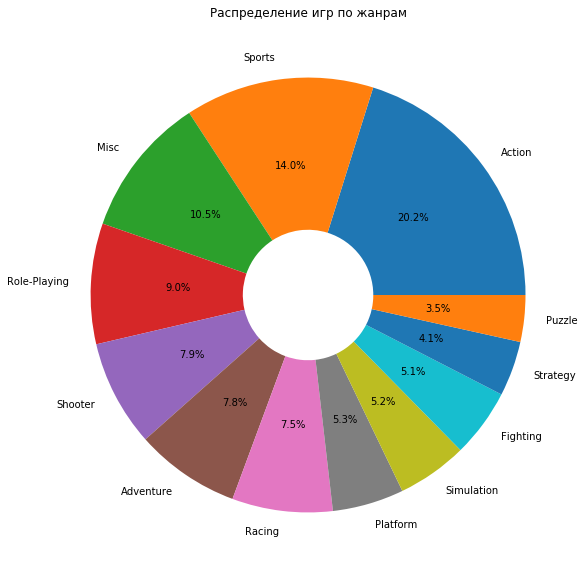

In [8]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))
ax.pie(games['genre'].value_counts(),autopct='%1.1f%%', labels = games['genre'].value_counts().index,wedgeprops=dict(width=.7))

ax.set_title("Распределение игр по жанрам")


plt.show()

Вывод:
---
больше всего игр выпускается в жанрах: "спорт", "Экшн", "разное"

Рейтинг
---


In [9]:
print("В столбце рейтинг {} пустых значений".format(games['rating'].isna().sum()))
rating_pivot = games.pivot_table(index='rating',values='critic_score',aggfunc={'median'})
print(rating_pivot)

В столбце рейтинг 6764 пустых значений
        median
rating        
AO        93.0
E         70.0
E10+      68.0
K-A       92.0
M         74.0
RP        63.0
T         71.0


__Обработка значений 'tbd' и пустых значений в столбце user_score и critic_score__

Рейтинг 'tbd' означает to be discussed или to be determined, что означает, что для вывода рейтинга недостаточно данных.
Попробуем проследить зависимость рейтинга от имеющихся данных.
Наибольшая корреляция по методу Спирмана у оценок юзеров с оценками критиков.
Значение tbd чаще всего встречается в играх с рейтингом Е и примерно одинаково распределено по играм всех жанров. Возьмем медианное значение оценок пользователей по жанру и заполним им пустые значения.

In [10]:
games_critic=games.groupby("genre")['critic_score'].mean().to_dict()
print(games_critic)

def critic_filler(row):
    if np.isnan(row['critic_score']):      
        return games_critic.get(row['genre'])
    return row['critic_score']
games['critic_score'] = games.apply(critic_filler,axis=1)
print(games.isna().sum())

{'Action': 66.62910052910053, 'Adventure': 65.3312693498452, 'Fighting': 69.21760391198045, 'Misc': 66.61950286806884, 'Platform': 68.05835010060362, 'Puzzle': 67.42410714285714, 'Racing': 67.96361185983828, 'Role-Playing': 72.65264586160109, 'Shooter': 70.18114406779661, 'Simulation': 68.61931818181819, 'Sports': 71.96817420435511, 'Strategy': 72.08609271523179}
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         6699
rating             6764
dtype: int64


In [11]:
games_not_tbd = games.query('user_score != "tbd"')
games_not_tbd['user_score']=games_not_tbd['user_score'].astype('float64')
games_not_tbd=games_not_tbd.dropna()
games_not_tbd_dict=games_not_tbd.groupby("genre")['user_score'].median().to_dict()

def tbd_filler(row):
    if (row['user_score'] == "tbd") or np.isnan(float(row['user_score'])):      
        return games_not_tbd_dict.get(row['genre'])
    return row['user_score']
 
games['user_score'] = games.apply(tbd_filler, axis=1)
print(games.isna().sum())
games['user_score']=games['user_score'].astype('float64')


name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6764
dtype: int64


Анализ суммарных продаж по всем регионам
---
Проанализируем, сколько в среднем собирает одна игра, а также сделаем графический анализ изменения количества продаж игр по годам.
Проведем анализ, как долго в среднем держится наиболее популярная платформа на рынке.

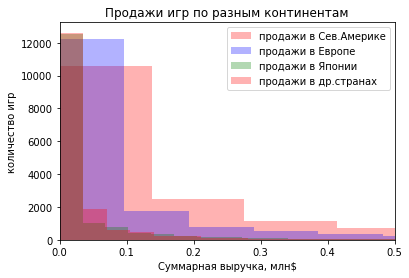

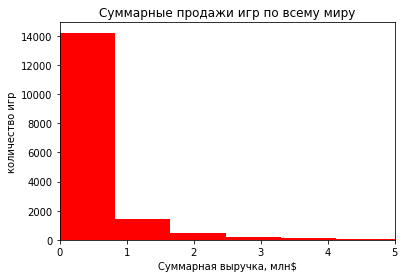

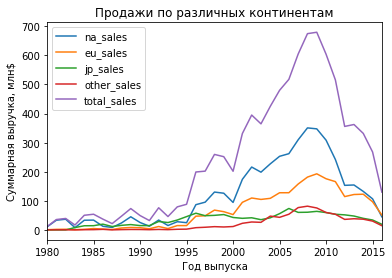

In [12]:
fig, ax = plt.subplots()
ax.hist(games['na_sales'], color='r',bins=300,alpha=0.3, label='продажи в Сев.Америке')
ax.hist(games['eu_sales'], color='b',bins=300,alpha=0.3, label='продажи в Европе')
ax.hist(games['jp_sales'],color='g', bins=300,alpha=0.3, label='продажи в Японии')
ax.hist(games['other_sales'], color='r',bins=300,alpha=0.3, label='продажи в др.странах')
ax.set_xlabel('Суммарная выручка, млн$')
ax.set_ylabel('количество игр')
ax.legend()
ax.set_title('Продажи игр по разным континентам')
ax.set_xlim(xmin=0, xmax=0.5)
plt.show()
#создадим новый столбец с сумарными сборами
fig, ax = plt.subplots()
games['total_sales']= games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']
ax.hist(games['total_sales'], color='r',bins=100)
ax.set_title('Суммарные продажи игр по всему миру')
ax.set_xlabel('Суммарная выручка, млн$')
ax.set_ylabel('количество игр')
ax.set_xlim(xmin=0, xmax=5)
plt.show()
games_df = games[[x for x in games.columns if 'sales' in x] + ['year_of_release']]
games_df.groupby('year_of_release').sum().plot(title= 'Продажи по различных континентам')
plt.xlabel("Год выпуска")
plt.ylabel("Суммарная выручка, млн$")
plt.show()

# Шаг 3. Исследовательский анализ данных.
1. •	Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

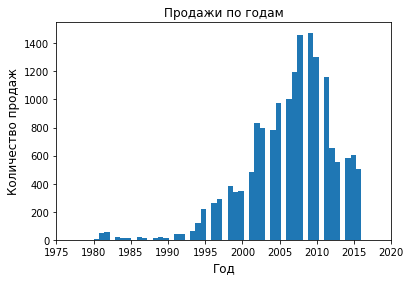

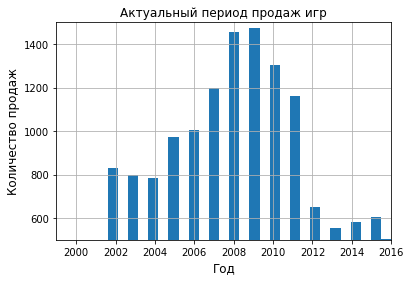

max     min
platform                
XOne      2016.0  2013.0
3DS       2016.0  2011.0
X360      2016.0  2005.0
WiiU      2016.0  2012.0
Wii       2016.0  2006.0
PSV       2016.0  2011.0
PC        2016.0  1985.0
PS4       2016.0  2013.0
PS3       2016.0  2006.0
PSP       2015.0  2004.0
DS        2013.0  1985.0
PS2       2011.0  2000.0
DC        2008.0  1998.0
XB        2008.0  2000.0
GBA       2007.0  2000.0
GC        2007.0  2001.0
PS        2003.0  1994.0
N64       2002.0  1996.0
WS        2001.0  1999.0
GB        2001.0  1988.0
SAT       1999.0  1994.0
SNES      1999.0  1990.0
PCFX      1996.0  1996.0
NG        1996.0  1993.0
3DO       1995.0  1994.0
TG16      1995.0  1995.0
NES       1994.0  1983.0
SCD       1994.0  1993.0
GEN       1994.0  1990.0
GG        1992.0  1992.0
2600      1989.0  1980.0

count     98.00
sum      255.46
Name: total_sales, dtype: float64


In [13]:
games['year_of_release'].plot(xlim=(1975,2020),kind='hist',bins=50,title=('Продажи по годам'))
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.show()
games['year_of_release'].plot(xlim=(1999,2016),ylim=(500,1500),kind='hist',bins=70,title=('Актуальный период продаж игр'),grid=True)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.show()
games_actual_period =(
    games.pivot_table(index='platform',values='year_of_release',aggfunc={'min','max'}).sort_values(by='max', ascending=False))
display(games_actual_period)
print(games[games['platform'] == "GB"]['total_sales'].agg({'sum','count'}))

Вывод
--
с 2002 по 2016 год не выпускалось менее 500 игр в год
У GameBox (GB) были высокие продажи, однако продано было всего 98 игр, что портит статистику, поэтому отбросим их продажи, примем началом актуального периода 2002 год (Геймбокс закончили выпускать в 2001ом).

2.	Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [14]:
games_actual_years = games.query('2002<=year_of_release<=2015')
games_sales_to_platform = games_actual_years.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(15)
games_top_prices =(
    games.query('platform in @games_sales_to_platform.index').
    pivot_table(index='platform',values='year_of_release',aggfunc={'min','max'})
)
merged_sales = pd.concat([games_top_prices,games_sales_to_platform],axis=1,sort=True)
merged_sales['total_time']=merged_sales['max']-merged_sales['min']
merged_sales = merged_sales.sort_values(by='total_sales',ascending=False)
print(merged_sales)
print("\nсредний срок существования 5 самых прибыльных платформ: {:.0f} лет"
      .format(merged_sales['total_time'].head(5).median()))


         max     min  total_sales  total_time
PS2   2011.0  2000.0      1050.17        11.0
X360  2016.0  2005.0       969.90        11.0
PS3   2016.0  2006.0       936.05        10.0
Wii   2016.0  2006.0       907.33        10.0
DS    2013.0  1985.0       806.10        28.0
PSP   2015.0  2004.0       294.05        11.0
GBA   2007.0  2000.0       256.25         7.0
PS4   2016.0  2013.0       244.89         3.0
3DS   2016.0  2011.0       243.86         5.0
XB    2008.0  2000.0       234.49         8.0
PC    2016.0  1985.0       194.10        31.0
GC    2007.0  2001.0       172.59         6.0
XOne  2016.0  2013.0       133.17         3.0
WiiU  2016.0  2012.0        77.59         4.0
PSV   2016.0  2011.0        49.82         5.0

средний срок существования 5 самых прибыльных платформ: 11 лет


4. Не учитывайте в работе данные за предыдущие годы.

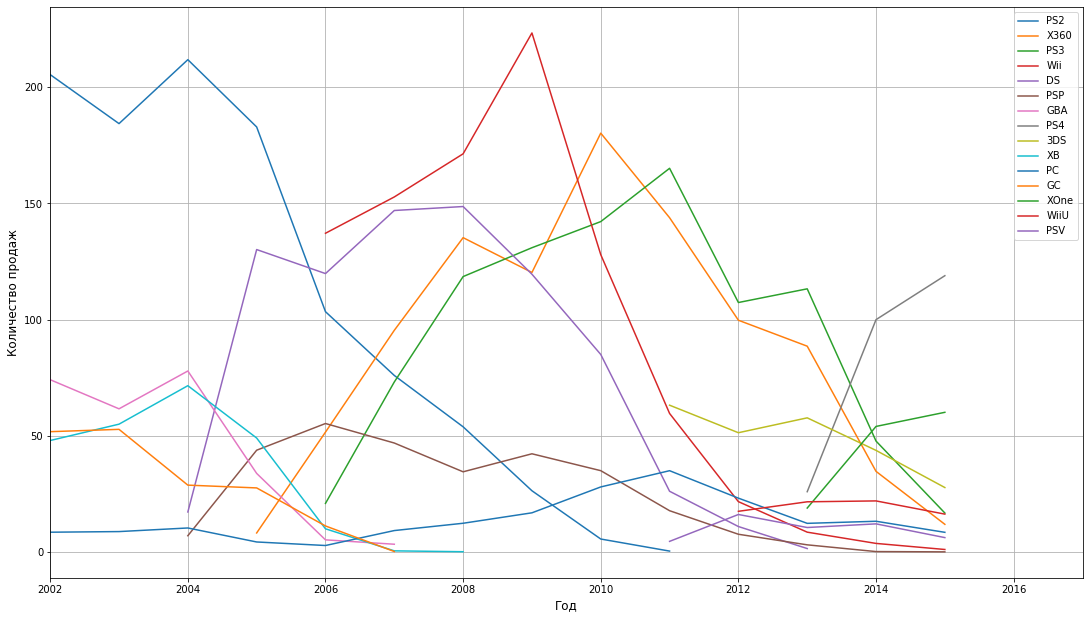

In [15]:
%matplotlib inline  
games_actual_years = games.query('2002<=year_of_release<=2015')[games['platform'].isin(merged_sales.index)]
fig,ax=plt.subplots()

for i in range(len(merged_sales)):
    ax.plot(games_actual_years[games_actual_years['platform'] == merged_sales.index[i]]
            .groupby('year_of_release')['total_sales'].sum(),label=str(merged_sales.index[i]))
    
plt.legend()
plt.grid(True)
fig = plt.gcf() 
plt.xlim(2002,2017)
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.show()


5. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

#### Вывод: 
В 2009 -2011 гг. были пики продаж платформ GB, GBA, PS3
Затем продажи начали падать, на 2013 год наиболее продаваемыми остались PS3,PS4, GBA, 3DS.  У PS4 заметен наиболее резкий рост продаж с момента запуска. Резкий спад , вероятно, обусловлен неполной статистикой за 2016 год. Так что, отдадим первенство в номинации "перспективная платформа" именно ей. Также XOne демонстрирует рост.

__Проверим, в каких регионах игры на PS4 продаются лучше всего__

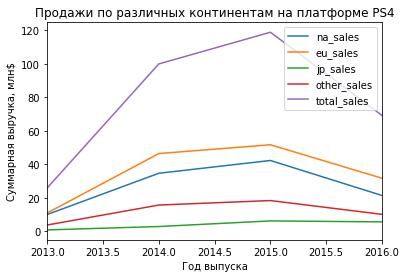

In [16]:
games_df_PS4 = games.query('platform=="PS4"')[[x for x in games.columns if 'sales' in x] + ['year_of_release']]
# games_df_PS4 = games_df.query('platform == "PS4"')
games_df_PS4.groupby('year_of_release').sum().plot(title= 'Продажи по различных континентам на платформе PS4')
plt.xlabel("Год выпуска")
plt.ylabel("Суммарная выручка, млн$")
plt.show()

#### Вывод
Лучше всего игры на PS4 продавать в Северной Америке.


6.	Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

In [17]:
# создаем Box trace для каждого жанра из наших данных
# для более наглядного отображения ограничим общую сумму продаж для игр в актуальном промежутке времени до 2млн$
games_actual_years = games.query('2002 <= year_of_release <=2016 and total_sales <=2')[games['platform'].isin(merged_sales.index)]
games_top_platforms_sorted = games_actual_years.groupby('platform')['total_sales'].median().sort_values(ascending=False)
games_top_genre_sorted = games_actual_years.groupby('genre')['total_sales'].median().sort_values(ascending=False)
games_top_users_sorted = games_actual_years.groupby('genre')['user_score'].median().sort_values(ascending=False)
games_top_critics_sorted = games_actual_years.groupby('platform')['critic_score'].median().sort_values(ascending=False)
# print(games_top_platforms_sorted.index)




data_platform = []
for platform in games_top_platforms_sorted.index:
    data_platform.append(
        go.Box(y=games_actual_years[games_actual_years['platform']==platform].total_sales, name=platform)
    )

fig = go.Figure(
    data=data_platform,
    layout=dict(title=dict(text="Зависимость Продаж по всем регионам от платформы"))
)

fig.show()    
    
# iplot(data_platform, show_link = False)


data_genre = []
for genre in games_top_genre_sorted.index:
    data_genre.append(
        go.Box(y=games_actual_years[games_actual_years['genre']==genre].total_sales, name=genre)
    )
# визуализируем данные


fig = go.Figure(
    data=data_genre,
    layout=dict(title=dict(text="Зависимость суммарных продаж от жанра"))
)

fig.show()
# iplot(data_genre,show_link = False)

data_genre = []
for genre in games_top_users_sorted.index:
    data_genre.append(
        go.Box(y=games_actual_years[games_actual_years['genre']==genre].user_score, name=genre)
    )
# визуализируем данные
fig = go.Figure(
    data=data_genre,
    layout=dict(title=dict(text="Зависимость пользовательского рейтинга от жанра"))
)

fig.show()
# plot(data_genre,show_link = False)

data_platform = []
for platform in games_top_critics_sorted.index:
    data_platform.append(
        go.Box(y=games_actual_years[games_actual_years['platform']==platform].critic_score, name=platform)
    )

fig = go.Figure(
    data=data_platform,
    layout=dict(title=dict(text="Зависимость рейтинга критиков от платформы"))
)

fig.show()    
    


Вывод
---
- Медианное значение продаж для разных платформ различается не сильно, наибольшее медианное значение у XBox 360.
- Также продажи для всех жанров находятся на одном уровне.
- Самое высокое среднее значение у жанров Sports и Shooter.
- Стратегии же имеют самый высокий средний рейтинг у пользователей.
- Игры на РС выше всего оенивают критики

(много блоков до этого менял местами, поэтому вывод про рейтинг появился выше, чем сам анализ).

7. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.


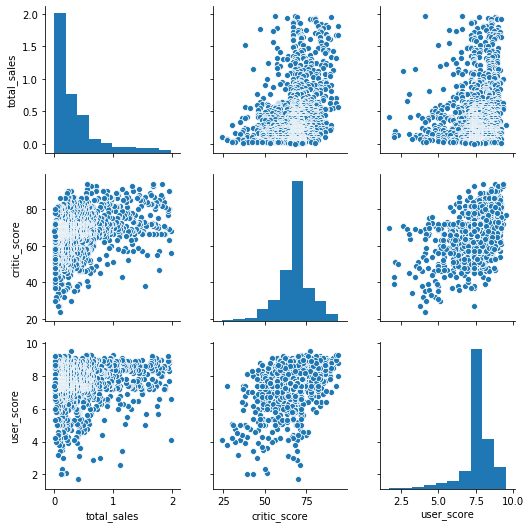

In [18]:
columns = ['total_sales','critic_score','user_score']
# print(games_actual_years.query('platform == "PS2"'))
sns.pairplot(games_actual_years.query('platform == "PS2"')[columns])

Вывод
---
Из графика рассеяния наиболее продаваемой платформы (PS2) можно сделать вывод, что при высокие продажи возможны только при высоком рейтинге критиков и юзеров. Например, игры, суммарные продажи которых составляют 1млн$ и выше, имеют рейтинг выше 60 и 6 соответственно.
Само же распредление отзывов критиков и юзеров имеет нормальное распределение, скошенное влево.


8. Соотнесите выводы с продажами игр на других платформах.



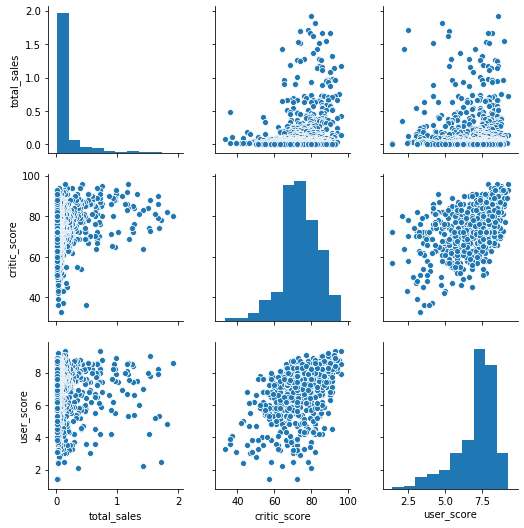

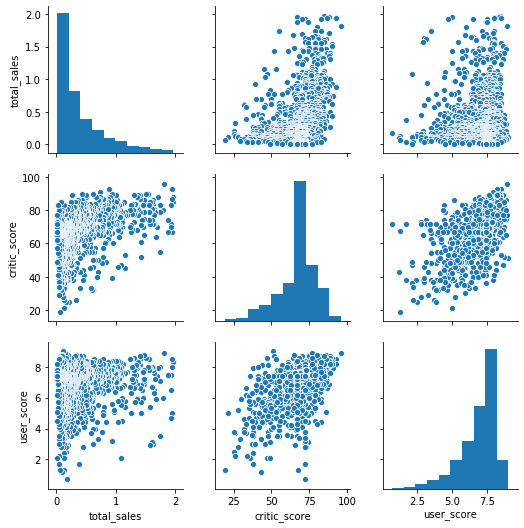

In [19]:
sns.pairplot(games_actual_years.query('platform == "PC"')[columns])
sns.pairplot(games_actual_years.query('platform == "X360"')[columns])

Вывод
---
Для примера взяли платформу PC и Х360
На них ситуация идентичная, за разницей в том, что отзывы юзеров более рассеяны, т.к. не профессиональные геймеры являются более субъективными критиками, однако тенденция увеличения продаж при высоком рейтинге сохраняется

9. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Согласно графику боксплот, третий квартиль находится вблизи значения 0.5 миллиона $ и выше  для жанров: 'Platform','Shooter', ' Fighting' и 'Sports'

Категоризация значений. Корреляция
---
Для каждого объекта определим числовое значение для рейтинга и жанра игры для дальнейшей обработки.

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(games_actual_years['genre'])
games_actual_years['genre_type'] = le.transform(games_actual_years['genre'])



In [21]:
# можно было по-другому
# словарь жанр: индекс
d = {g:idx for idx, g in enumerate(games_actual_years['genre'].unique())}
# r = {g:idx for idx, g in enumerate(games['rating_type'].unique())}

[ 0  1  2  3  4  5  6  7  8  9 10 11]


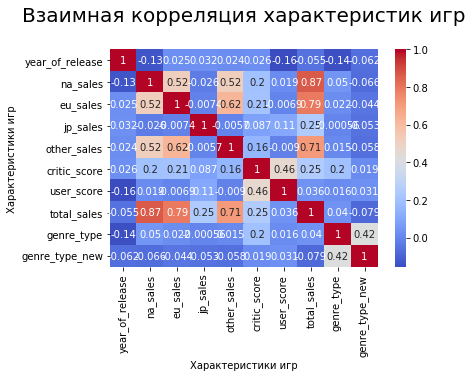

In [22]:
# применяем словарь
games_actual_years['genre_type_new'] = games_actual_years['genre'].map(d)
# games_actual_years['rating_type'] = games_actual_years['rating'].map(r)
print(games_actual_years['genre_type_new'].unique())

corr = games_actual_years.corr()
ax = sns.heatmap(corr,cmap='coolwarm',annot=True)
ax.set(xlabel='Характеристики игр', ylabel='Характеристики игр')
ax.set_title('Взаимная корреляция характеристик игр\n',fontsize=20)
plt.show()

#### Вывод.
1. Наибольший вклад в суммарные продажи вносит Сев.Америка. Продажи практически не зависят от года релиза.
2. Наибольшая зависимость от жанра есть у года выпуска и рейтинга.
3. Продажи сильнее всего зависят от рейтинга критиков. Также рейтинг критиков довольно сильно коррелирует с рейтингом пользователей.

# Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
1.	Самые популярные платформы (топ-5). Опишите различия в долях продаж.
2.	Самые популярные жанры (топ-5). Поясните разницу.
3.	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### 1. Построим график плотности распределения продаж игр в актуальный период времени для самых прибыльных платформ по регионам

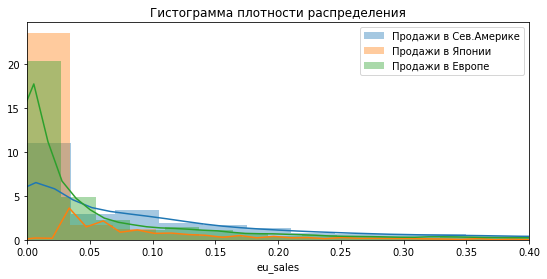

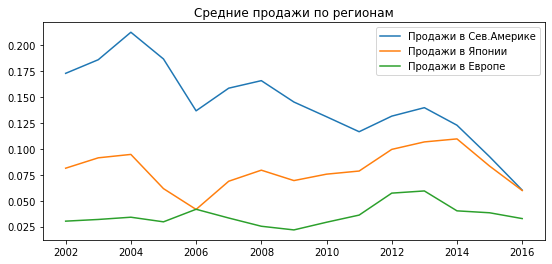

In [23]:
fig, ax = plt.subplots(figsize = (9,4))


ax1 =sns.distplot(games_actual_years.na_sales,label='Продажи в Сев.Америке')
ax2=sns.distplot(games_actual_years.jp_sales,label='Продажи в Японии')
ax3=sns.distplot(games_actual_years.eu_sales,label='Продажи в Европе')
plt.xlim(0,0.4) # ограничим график для наглядности
ax.legend()
ax.set(title = "Гистограмма плотности распределения")

fig, ax = plt.subplots(figsize = (9,4))


ax.plot(games_actual_years.groupby('year_of_release')['na_sales'].mean(),label='Продажи в Сев.Америке')

ax.plot(games_actual_years.groupby('year_of_release')['eu_sales'].mean(),label='Продажи в Японии')
ax.plot(games_actual_years.groupby('year_of_release')['jp_sales'].mean(),label='Продажи в Европе')
# plt.xlim(0,0.4) # ограничим график для наглядности
ax.legend()
ax.set(title = "Средние продажи по регионам")
plt.show()

В Европе реализуется больше игр, однако почти все с небольшими продажами. Доля игр с высокими продажами снижается, и игры, которые заработали более 0.05 млн$, чаще покупают в Сев.Америке, чем в Европе.


#### 2. Выделим самые популярные жанры

In [24]:
games_actual_pivot = games_actual_years.groupby('genre')['total_sales'].sum().sort_values(ascending=False).head()   
print()
print(games_actual_pivot)


genre
Action          883.53
Sports          581.98
Misc            399.68
Shooter         383.75
Role-Playing    337.45
Name: total_sales, dtype: float64


In [25]:
import scipy.stats as st
print(games['rating'].unique())
sales_pivot =(games_actual_years.pivot_table(index='rating', values='total_sales', aggfunc={'sum','median','count'}))
display(sales_pivot)
# print(games_actual_years)
x = games_actual_years['user_score']
y=games_actual_years['critic_score']
print("Таблица корреляции продаж от жанра:\nКорреляция Пирсона",st.pearsonr(x, y))  


['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


count  median      sum
rating                        
AO          1   1.960     1.96
E        3470   0.170  1139.43
E10+     1356   0.190   445.53
EC          8   0.220     1.75
M        1344   0.235   572.53
RP          3   0.040     0.09
T        2636   0.180   877.12

Таблица корреляции продаж от жанра:
Корреляция Пирсона (0.464605925206636, 0.0)


#### Различия регионов для топ-5 платформ, топ-5 жанров, топ-5 рейтинг игр


X360
PS3
PS2
WiiU
Wii


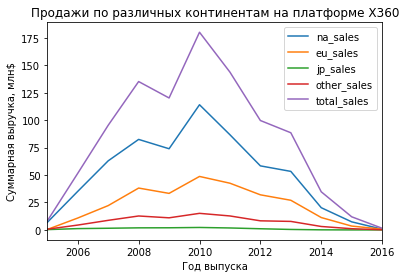

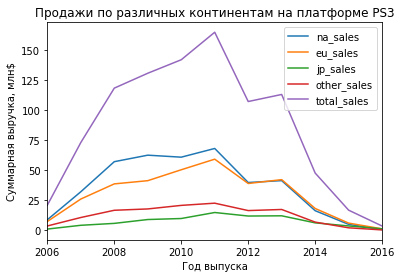

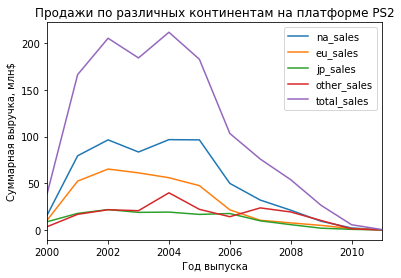

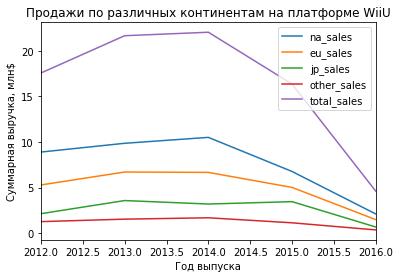

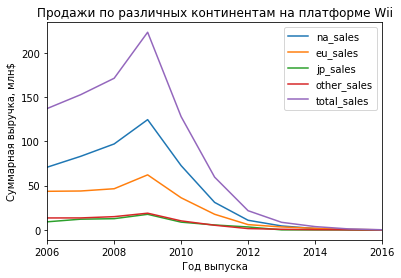

In [26]:
games_top5_platforms_sorted = games_actual_years.groupby('platform')['total_sales'].median().sort_values(ascending=False).head()
games_top5_genre_sorted = games_actual_years.groupby('genre')['total_sales'].median().sort_values(ascending=False).head()
games_top5_rating_sorted = games_actual_years.groupby('rating')['total_sales'].median().sort_values(ascending=False).head()
top5_platforms = []
for i in games_top5_platforms_sorted.index:
    top5_platforms = games[games['platform'] == i][[x for x in games.columns if 'sales' in x] + ['year_of_release']]
    top5_platforms.groupby('year_of_release').sum().plot(title= 'Продажи по различных континентам на платформе {}'.format(i))
    print(i)
    plt.xlabel("Год выпуска")
    plt.ylabel("Суммарная выручка, млн$")
plt.show()

__Вывод__
Для каждой из топ 5 платформ выделяются пики в определенный промежуток времени. Иногда пиков несколько.
Однако, для всех платформ верно то, что наибольшие продажи в Северной Америке

Shooter
Sports
Platform
Fighting
Action


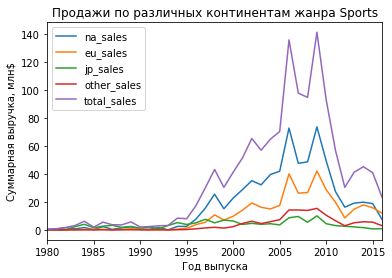

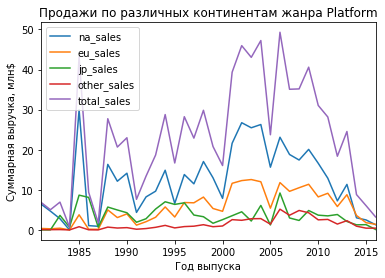

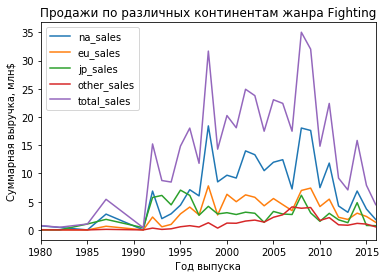

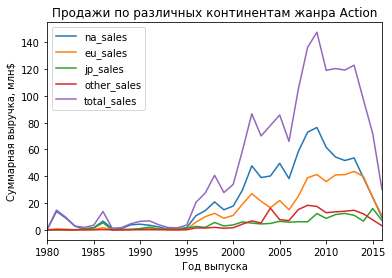

In [27]:
for i in games_top5_genre_sorted.index:
    top5_platforms = games[games['genre'] == i][[x for x in games.columns if 'sales' in x] + ['year_of_release']]
    top5_platforms.groupby('year_of_release').sum().plot(title= 'Продажи по различных континентам жанра {}'.format(i))
    print(i)
    plt.xlabel("Год выпуска")
    plt.ylabel("Суммарная выручка, млн$")
plt.show()

AO
M
EC
E10+
T


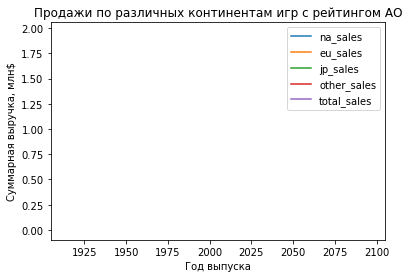

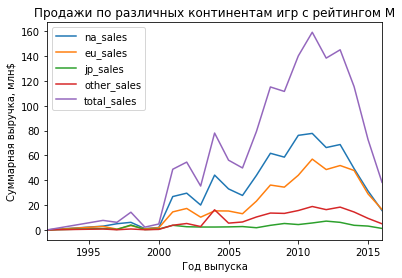

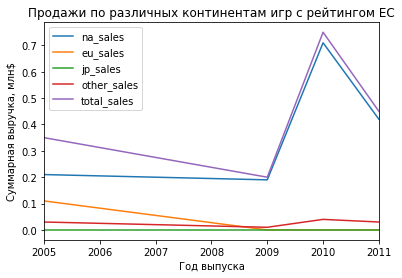

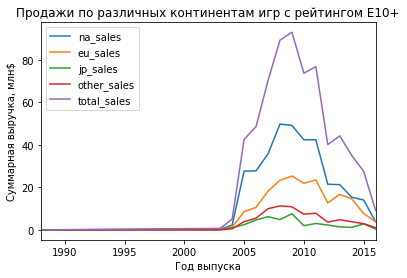

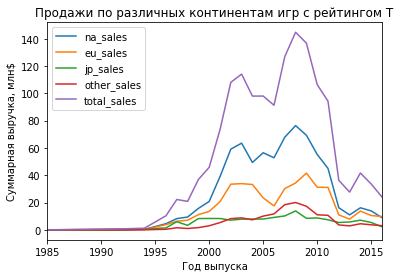

In [28]:
for i in games_top5_rating_sorted.index:
    top5_platforms = games[games['rating'] == i][[x for x in games.columns if 'sales' in x] + ['year_of_release']]
    top5_platforms.groupby('year_of_release').sum().plot(title= 'Продажи по различных континентам игр с рейтингом {}'.format(i))
    print(i)
    plt.xlabel("Год выпуска")
    plt.ylabel("Суммарная выручка, млн$")
plt.show()

__Вывод__
У продаж игр определенного жанра наиболее неравномерный и непредсказуемый график. Причин может быть множество. Вероятно, жанр сейчас становитсяя довольно размытым понятием, игры соответствуют сразу нескольким, а также мода определеяет популярные жанры.
Интересно то, почти все игры с рейтингом ЕС выпускались в Северной Америке.

Выделяются жанры с самыми высокими продажами : Sports, Shooter и Action

### Вывод
Самые высокие продажи, как правило, в Северной Америке. Игры рейтингов E, E10+, M и Т популярнее всего во всех странах. 
Игр с рейтингом AO, EC, RP слишком мало, чтоы учитывать их в анализе рейтингов.
Чаще всего выпускают игры с рейтингом Е, но средние продажи этих игр на одном уровне с Е10+ и Т.
Игры с рейтингом М имеют самые высокие продажи.

# 5. Гипотезы

#### Гипотеза №1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

- Нулевая гипотеза Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Альтернативная гипотеза Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [29]:
from scipy import stats as st

xbox_games=games.query('platform =="XOne"')['user_score']
pc_games = games.query('platform=="PC"')['user_score']

alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(xbox_games, pc_games)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 3.6468225375489976e-05
Отвергаем нулевую гипотезу


Статистическая вероятность того, что генеральные совокупности оценок пользователей двух платформ одинаковы, слишком мала, чтобы принять нулевую гипотезу. Статистическая разница велика.

In [30]:
# производим 1000 выборок и рассчитываем среднее
xbox_smp_mean = pd.Series([xbox_games.sample(frac=1, replace=True).mean() for _ in range(1000)])
pc_smp_mean = pd.Series([pc_games.sample(frac=1, replace=True).mean() for _ in range(1000)])

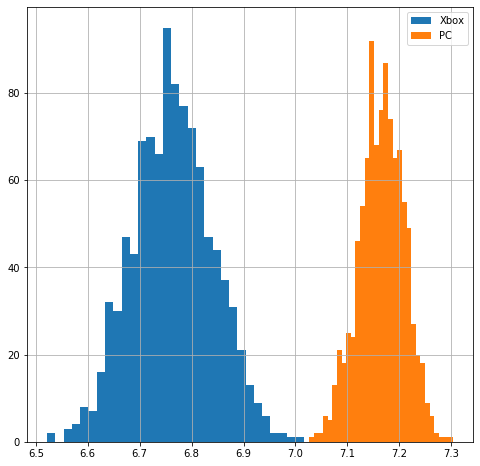

In [31]:
# строим распределения
plt.figure(figsize=(8, 8))
plt.hist(xbox_smp_mean, bins=31, label='Xbox')
plt.hist(pc_smp_mean, bins=31, label='PC')
plt.legend()
plt.grid()
plt.show()

Вот о такой разнице говорит статистический тест, хотя абсолютная разница - менее 1 балла

#### Гипотеза №2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.
Альтернативная гипотеза - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различаются.


In [32]:
action_games=games.query('genre =="Action"')['user_score']
sports_games = games.query('genre=="Sports"')['user_score']

alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(action_games, sports_games)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5342570517131008
Не получилось отвергнуть нулевую гипотезу


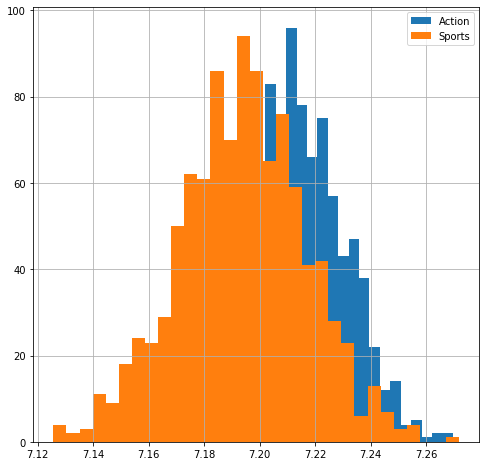

In [33]:
# производим 1000 выборок и рассчитываем среднее
action_smp_mean = pd.Series([action_games.sample(frac=1, replace=True).mean() for _ in range(1000)])
sports_smp_mean = pd.Series([sports_games.sample(frac=1, replace=True).mean() for _ in range(1000)])
# строим распределения
plt.figure(figsize=(8, 8))
plt.hist(action_smp_mean, bins=31, label='Action')
plt.hist(sports_smp_mean, bins=31, label='Sports')
plt.legend()
plt.grid()
plt.show()

### Вывод
Хоть в рейтинге этих жанров есть различия, статистически имеется слишком большая вероятность, чтобы делать вывод о значимом различии между средними рейтингами двух жанров.


Для проверки гипотез был принят критический уровень статистической значимости равный 0.05, который определяет статистические различия двух генеральных совокупностей. В случае, если статистика разности меньше альфа, т.е. статистическая вероятность того ,что значение одной генеральной совокупности находится в доверительном интервале другой генеральной совокупности, высока ,чтобы отвергнуть гипотезу о равенстве ,и наоборот.

В итоге, не получилось отвергнуть гипотезу о равенстве пользовательских рейтингов двух жанров Action и Sports. Статистическая значимость различий достаточно мала.

# Общий вывод

1. До 2001 года индустрия игр была развита не сильно, и игры выпускались в малых количествах. После 2001 года пошел рост количества, который достиг пика в 2007-2010 годах. Это ,вероятно ,связано с тем, что персональный компьютер и приставки стали доступнее и появились у большинства пользователей. После этих годов происходит уменьшение количества игр. Возможно, количество игр постепенно переходит в качество.

2. Самыми прибыльными платформами оказались:
 - PS2        1255.77  млн;
 - X360         971.42 млн;        
 - PS3          939.65  млн;      
 - Wii         907.51   млн;      
 - DS           806.12   млн; 
 - Средний срок существования 5 самых прибыльных платформ 11.8 лет.

3. Медианное значение продаж для разных платформ различается не сильно, однако GameBox сильно выбивается в сторону больших продаж.Также медианный рейтинг критиков для всех видов платформ не сильно отличается друг от друга. Вероятно, рейтинг и продажи больше зависят от игры и года.

4. В Европе реализуется больше игр, однако почти все с небольшими продажами. Доля игр с высокими продажами ниже, и игры, которые заработали более 0.05 млн, чаще покупают в Сев.Америке, чем в Европе. Япония обеспечивает также неплохие продажи, и даже сравнима с Европой на уровне 0.03млн, однако население Японии ниже, чем в других регионах, поэтому соревноваться в численных значениях продаж сложно.

5. Самые высокие продажи, как правило, в Северной Америке. Игры рейтингов E, E10+, M и Т популярнее всего во всех странах.

6. Были проверены две гипотезы:

    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Данная гипотеза не подтвердилась. Рейтинги значительно отличаются
    - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Данная гипотеза также не подтвердилась - рейтинги этих жанров статистически отличаются не сильно.

7. Оценки критиков и юзеров значительно влияют на продажи. Имеется прямая зависимость, однако оценки юзеров более рассеяны, так как они ,вероятно, более субъективны, и плохо продаваемая игра может понравиться части юзеров, а также оценка юзеров, в отличии от критиков, менее способна повлиять на продажи, так как не всегда предаётся общественной огласке.

8. Перспективная платформа.
В 2009 -2011 гг. были пики продаж платформ GB, GBA, PS3. Затем продажи начали падать, на 2013 год наиболее продаваемыми остались PS3,PS4, GBA, 3DS.  У PS4 заметен наиболее резкий рост продаж с момента запуска. Резкий спад , вероятно, обусловлен неполной статистикой за 2016 год. Так что, отдадим первенство в номинации "перспективная платформа" именно ей.

# Рекомендации компании "Стримчик"

1. Самый большой потенциал - у платформы PS4. Стоит вложить деньги в игры на этой платформе, т.к. она выделяется на фоне других наиболее ярко в последнее время. в 2017 году её определенно ждет успех. Лучший регион для реализации таких игр - Северная Америка. Она приносит наибольшую выручку. Лучший жанр для игры -Спорт или Шутер.
2. Не стоит забывать про XBox. Также самые высокие продажи по всего миру у XBox360. XOne является перспективной на 2017 год. Стоит продавать также игры на этой платформе, но в меньшем количестве. Игры на PC, в свою очередь, лидируют в рейтингах критиков ,которые напрямую влияют на продажи. Так что не забываем и про эту платформу.
3. Лучший жанр для игр - М, так как такие игры покупают в среднем чаще, и они приносят больше денег. Игр с рейтингом Е выпускают много, на них также всегда есть спрос, так как они подходят для всех.